# Initial Set Up

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import sklearn
import _pickle as cPickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve

# Preliminary Visualisation and Processing

In [10]:
messages = [line.rstrip() for line in open('./Data/Raw.csv')]
print(len(messages))
for message_no, message in enumerate(messages[1:11]):
    print(message_no, message)

5729
0 "Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : y

## Splitting the `text` into Subject & Content

In [11]:
source = open('Data/Raw.csv', 'r')
reader = csv.reader(source)
next(reader)
i = 0
subjects = []
contents = []
labels = []

for line in reader:
    i += 1
    text = line[0]
    label = line[1]
    if label == '0':
        label = "spam"
    else: 
        label = 'ham'
        
    try:
        subject = text[text.index("Subject") + len("Subject:")
                    : text.index("  ")].strip()
        content = text[text.index("  ") :].strip()
    except ValueError:
        subject = text[text.index("Subject") + len("Subject:")
                    :]
        content = ""
    subjects += [subject]
    contents += [content]
    labels.append(label)

df = pd.DataFrame({'subject': subjects,
                   'content': contents,
                   'label': labels})
df.to_csv('Data/Pre-processed.csv', index=False)

## Separating the Data into Training, Testing and Validation

In [12]:
def split_ttv(data, test_ratio, val_ratio):
    shuffled_indices = np.random\
                        .default_rng(seed=42)\
                        .permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    val_set_size = int(len(data) * val_ratio)
    test_indices = shuffled_indices[:test_set_size]
    val_indices = shuffled_indices[test_set_size:
        test_set_size + val_set_size]
    train_indices = shuffled_indices[test_set_size + val_set_size:]
    return (data.iloc[train_indices],
            data.iloc[test_indices],
            data.iloc[val_indices])

In [13]:
df = pd.read_csv('Data/Pre-processed.csv',
                 header=0)
train, test, validation = split_ttv(df, 0.2, 0.1)
train.to_csv('Data/train.csv', index=False)
test.to_csv('Data/test.csv', index=False)
validation.to_csv('Data/validation.csv', index=False)

## Visualising the New Data

In [43]:
messages = pd.read_csv('Data/train.csv',
                       header=0)
messages = messages.dropna()

<Axes: ylabel='Frequency'>

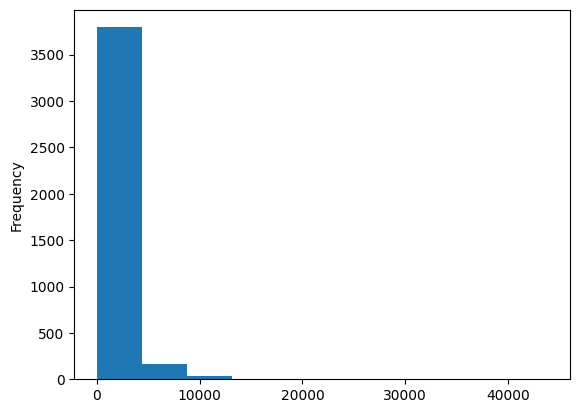

In [44]:
messages['content length'] = messages['content'].map(lambda text: len(str(text)))
messages['content length'].plot(bins=10, kind='hist')

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

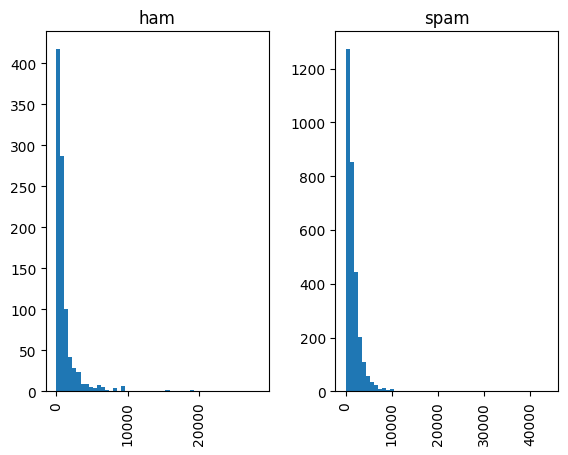

In [45]:
messages['content length'].describe()
messages.hist(column='content length', by='label', bins=50)

# NLP Pre-Processing

In [48]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [49]:
messages['content'].head().apply(split_into_lemmas)

0    [u, urgent, vince, can, you, please, check, wi...
1    [i, have, scheduled, the, meeting, for, friday...
2    [direct, email, blaster, the, program, will, s...
3    [since, several, of, you, will, be, out, on, t...
4    [jeff, the, newsletter, is, addressed, to, a, ...
Name: content, dtype: object

## Data to Vectors

In [50]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas)\
                    .fit(messages['content'])
print(len(bow_transformer.vocabulary_))

29222


In [54]:
messages_bow = bow_transformer\
                .transform(messages['content'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % \
        (100.0 * messages_bow.nnz / \
        (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (4008, 29222)
number of non-zeros: 497368
sparsity: 0.42%


In [55]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)

  (0, 28997)	0.04953074762715507
  (0, 28992)	0.03180129442919003
  (0, 28980)	0.06389011560122514
  (0, 28742)	0.04310439589853908
  (0, 28694)	0.020221546794920574
  (0, 28648)	0.026710593141823207
  (0, 28552)	0.015714506330772506
  (0, 28399)	0.028456838225068927
  (0, 28344)	0.026314287246248947
  (0, 27822)	0.05236361019342848
  (0, 27734)	0.053187853234117226
  (0, 27426)	0.11489588609615185
  (0, 27251)	0.06584956808010807
  (0, 26973)	0.0977712333031231
  (0, 26931)	0.03215874877863836
  (0, 26763)	0.286930458184783
  (0, 26437)	0.0773865721607006
  (0, 26408)	0.04653073292422569
  (0, 26242)	0.03109860492160738
  (0, 26166)	0.056623095959939536
  (0, 26164)	0.08283354800571609
  (0, 26153)	0.021522910474594693
  (0, 26150)	0.028916573433418875
  (0, 26050)	0.06317108900568381
  (0, 25975)	0.08688024924803858
  :	:
  (4007, 5991)	0.015987294434270296
  (4007, 5480)	0.017927716645076343
  (4007, 5307)	0.048019495985005385
  (4007, 4670)	0.01724650204240697
  (4007, 4444)	0.0230